# C-MAPSS Aircraft Engine RUL Prediction

En los últimos años, dentro del campo de la Gestión de Activos Físicos, diversas investigaciones han propuesto la utilización de modelos de deep learning cada vez más sofisticados para la estimación y predicción del tiempo de vida remanente (RUL) de equipos y/o componentes particulares. El tiempo de vida remanente o Remaining Useful Life (RUL) consiste en una variable utilizada principalmente para describir la degradación temporal de un activo durante su operación y describe el tiempo de operación remanente del activo antes de que ocurra su falla. De este modo, mejores estimadores de esta variable resultan de suma importancia a la hora de gestionar e implementar mejores políticas de mantenimiento y operación.

  <img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_03/bin/scatter_rul.png" height="200"> <img src="https://www.researchgate.net/profile/Xiaolei_Fang/publication/310789705/figure/fig2/AS:462413100261377@1487259282977/Simplified-diagram-of-engine-simulated-in-C-MAPSS-6.png" height="200">

El Comercial Modular Aero-Propulsion System Simulation (C-MAPSS) es un software desarrollado por NASA como ambiente de simulación de motores de reacción tipo turbofán. Así, esta herramienta permite la implementación y evaluación de algoritmos de control y diagnóstico sobre la operación de un motor turbofán de 90.000 lbf de propulsión.

A diferencia de los workshops del curso, en esta tarea trabajarán con los datasets `CMAPSS_FD001_raw.npz` y `CMAPSS_FD004_raw.npz`. Estos datasets ya han sido procesados para extraer las ventanas de datos de cada una de las simulaciones. No obstante, los datos esta vez no se encuentran normalizados, por lo que procuren utilizar `MinMaxScaler` previo al entrenamiento de sus modelos.

    Dataset FD001
    - Condiciones Operacionales: 1
    - Modos de Falla: 1
    - Simulaciones de Entrenamiento: 100
    - Simulaciones de Testing: 100
    - Timesteps: 30
    - Sensors: 19

    Dataset FD004
    - Condiciones Operacionales: 6
    - Modos de Falla: 2
    - Simulaciones de Entrenamiento: 249
    - Simulaciones de Testing: 237
    - Timesteps: 30
    - Sensors: 19

Cada uno de los datasets cuenta con los conjuntos `X_train`, `Y_train`, `X_test` e `Y_test`, previamente definidos. Similar al dataset utilizado en los workshops, estos conjuntos presentan las ventanas de datos separadas por simulación. Recuerden utilizar `np.vstack` y `np.reshape` para reestructurar los arreglos a una forma compatible con las estructuras y capas de `keras`.

Para facilitar la carga de los archivos a un entorno de Google Colab, los archivos han sido cargados a un Google Drive. Copien el siguiente bloque de código en su Notebook para ejecutar la rutina de descarga. Los archivos serán cargados en el directorio `\content\datasets`.

In [1]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# inicializar GoogleDrive con credenciales de autorización
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# crear carpeta para descargar los archivos .npz
!mkdir /content/datasets

# Google Drive IDs para descargar los archivos .npz
files_id = [('CMAPSS_FD001_raw.npz', '1ZcYauNQs_-QZMndP2THq6tQ53M6aWZJb'),
            ('CMAPSS_FD004_raw.npz', '1lbGpuYZFGjmcu-xiE1ehsqlhPC4S2cWN')]

# comenzar descarga
print('descargando datasets: ', end='')

for filename, id in files_id:
  save_path = os.path.join('/content/datasets', filename)

  # descargar y guardar en /content/datasets
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(save_path)

# indicar descarga terminada
print('done')

descargando datasets: done


In [42]:
import numpy as np

# cargar archivo npz
dataset = np.load('/content/datasets/CMAPSS_FD001_raw.npz', allow_pickle=True)

# sacar conjunto X_train
X_train = dataset['X_train']
Y_train = dataset['Y_train']
X_test = dataset['X_test']
Y_test = dataset['Y_test']

# print npz keys
print( list( dataset.keys() ) )

['X_train', 'Y_train', 'X_test', 'Y_test']


## Formato de Entrega

Los entregables de esta tarea son los siguientes.
- Jupyter Notebook (.ipynb): Todo el procesamiento de la tarea debe estar contenido en un único Notebook. Considere este archivo como un informe de metodología donde se reporten todos los pasos y bloques de código utilizados para resolver el problema. **Sea ordenado**; utilice comentarios en su código y bloques de texto para mejorar la legibilidad del Notebook.

- Reporte Resultados (.pdf): Este archivo debe contener los resultados obtenidos en su tarea, junto con un análisis correspondiente. Considere este documento como la sección de Resultados y Análisis de la tarea. En este sentido, debe mantener un formato de informe estándar.

## Exploración de los datos

In [20]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [50]:
# forma de las simulaciones
print([x.shape for x in X_train])

# se stackean las simulaciones de entrenamiento
X_train_ = np.vstack(X_train)
Y_train_ = np.vstack(Y_train)
print(X_train_.shape)
print(Y_train_.shape)

[(163, 30, 19), (258, 30, 19), (150, 30, 19), (160, 30, 19), (240, 30, 19), (159, 30, 19), (230, 30, 19), (121, 30, 19), (172, 30, 19), (193, 30, 19), (211, 30, 19), (141, 30, 19), (134, 30, 19), (151, 30, 19), (178, 30, 19), (180, 30, 19), (247, 30, 19), (166, 30, 19), (129, 30, 19), (205, 30, 19), (166, 30, 19), (173, 30, 19), (139, 30, 19), (118, 30, 19), (201, 30, 19), (170, 30, 19), (127, 30, 19), (136, 30, 19), (134, 30, 19), (165, 30, 19), (205, 30, 19), (162, 30, 19), (171, 30, 19), (166, 30, 19), (152, 30, 19), (129, 30, 19), (141, 30, 19), (165, 30, 19), (99, 30, 19), (159, 30, 19), (187, 30, 19), (167, 30, 19), (178, 30, 19), (163, 30, 19), (129, 30, 19), (227, 30, 19), (185, 30, 19), (202, 30, 19), (186, 30, 19), (169, 30, 19), (184, 30, 19), (184, 30, 19), (166, 30, 19), (228, 30, 19), (164, 30, 19), (246, 30, 19), (108, 30, 19), (118, 30, 19), (202, 30, 19), (143, 30, 19), (156, 30, 19), (151, 30, 19), (145, 30, 19), (254, 30, 19), (124, 30, 19), (173, 30, 19), (284, 30, 

In [45]:
print([y.shape for y in Y_train])
print(Y_train.shape)

[(163, 1), (258, 1), (150, 1), (160, 1), (240, 1), (159, 1), (230, 1), (121, 1), (172, 1), (193, 1), (211, 1), (141, 1), (134, 1), (151, 1), (178, 1), (180, 1), (247, 1), (166, 1), (129, 1), (205, 1), (166, 1), (173, 1), (139, 1), (118, 1), (201, 1), (170, 1), (127, 1), (136, 1), (134, 1), (165, 1), (205, 1), (162, 1), (171, 1), (166, 1), (152, 1), (129, 1), (141, 1), (165, 1), (99, 1), (159, 1), (187, 1), (167, 1), (178, 1), (163, 1), (129, 1), (227, 1), (185, 1), (202, 1), (186, 1), (169, 1), (184, 1), (184, 1), (166, 1), (228, 1), (164, 1), (246, 1), (108, 1), (118, 1), (202, 1), (143, 1), (156, 1), (151, 1), (145, 1), (254, 1), (124, 1), (173, 1), (284, 1), (170, 1), (333, 1), (108, 1), (179, 1), (184, 1), (184, 1), (137, 1), (200, 1), (181, 1), (125, 1), (202, 1), (170, 1), (156, 1), (211, 1), (185, 1), (264, 1), (238, 1), (159, 1), (249, 1), (149, 1), (184, 1), (188, 1), (125, 1), (106, 1), (312, 1), (126, 1), (229, 1), (254, 1), (307, 1), (173, 1), (127, 1), (156, 1), (171, 1)]


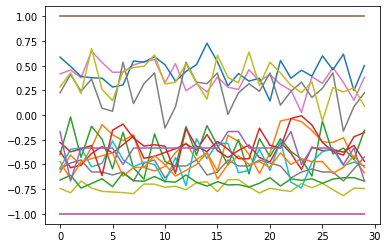

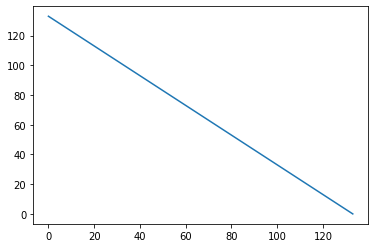

In [52]:
# escalar los datos
scaler = MinMaxScaler(feature_range=(-1,1))
x = scaler.fit_transform(X_train_.reshape(-1,19))
X_train_ = x.reshape(-1,30,19)

# plotear una simulacion
n = 28
plt.plot(X_train_[n])
plt.show()
plt.plot(Y_train[n])
plt.show()

## 1. Recurrent Models FD001

Para el dataset `FD001` deben implementar y entrenar dos modelos de pronóstico de RUL, utilizando capas RNN y LSTM, respectivamente.

Recuerden que este problema de pronóstico consiste en un problema de regresión, por lo que como se vio en clases, deben utilizar el `mean squared error` como métrica de evaluación y función de pérdida.

Ajusten los hiperparámetros de sus modelos tipo RNN y LSTM para reducir el `mse` sobre un conjunto de validación `(X_val, Y_val)` que deberán generar a partir de las simulaciones de entrenamiento. Luego, para cada modelo reporten:

- RMSE sobre conjunto de testing y tiempo de entrenamiento para tres (3) iteraciones de entrenamiento, junto con sus promedios.

Discutan sobre las diferencias a nivel de desempeño y tiempo de entrenamiento que se observan entre ambos tipos de redes. Fundamenten en base a la estructura teórica de estas celdas recurrentes.

Comenten sobre si en este caso se justifica el uso de capas LSTM.

In [ ]:
# RNN

## 2. Recurrent Models FD004

Utilizando la mejor arquitectura desarrollada en la sección anterior (sin cambiar sus hiperparámetros), entrenen el modelo sobre el dataset `FD004`. Luego, reporten:
- Utilizando las funciones `plot_RUL_scatter` y `plot_RUL_sorted` disponibles en el módulo `utils` del github del curso, grafiquen el desempeño del modelo sobre los conjuntos de testing de los datasets `FD001` y `FD004`.
- RMSE sobre el conjunto de testing de cada dataset para tres (3) iteraciones de entrenamiento, junto con sus promedios.

Comparen los resultados obtenidos sobre el dataset `FD004` con los observados en `FD001`, discutan sobre las diferencias a nivel de desempeño.

## 3. Convolutional and Recurrent Model
Utilizando la mejor arquitectura desarrolla en la primera sección y el dataset `FD001`, incorporen en la red una etapa de preprocesamiento convolucional que alimentará a la etapa recurrente de su modelo. En particular, noten que las ventanas temporales al ser de la forma `(n_timesteps, n_features)` pueden ser interpretadas como imágenes de un solo canal. De este modo, consideren:
- Utilicen `np.reshape` para reestructurar los conjuntos `X_train` y `X_test` de modo que sean compatibles con la estructura `Conv2D` de `keras`.
- Para conectar los `feature maps` resultantes de la etapa convolucional con la etapa recurrente deben utilizar la capa `TimeDistributed( Flatten() )` de `keras`. Pueden encontrar información sobre esta estructura en la documentación.

La idea es que con este preprocesamiento mejoren las métricas sobre el conjunto de evaluación. Una vez entrenado su modelo de predicción, reporten:
- Arquitectura Conv2D-RNN/LSTM utilizada.
- RMSE sobre el conjunto de testing para tres (3) iteraciones de entrenamiento, junto con su promedio.